In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Let's firstly define functions for scaling the data and fitting KMeans clustering. First function returns us KMeans criterion with clustering labels based on 10 random intializations. We use sklearn implementation which optimexes inertia as the fuctional.

In [2]:
def fit_kmeans(X, features, n_clusters, n_init):
    kmeans_criterion = []
    clustering_results = []
    for _ in range(n_init):
        clusterer = KMeans(n_clusters=n_clusters, n_init=1)
        predicted_labels = clusterer.fit_predict(X[features])
        clustering_results.append(predicted_labels)
        kmeans_criterion.append(clusterer.inertia_)
    return kmeans_criterion, clustering_results[np.argmin(kmeans_criterion)]

In [3]:
def scale_data(X):
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns = X.columns
    )
    
    return X_scaled
    

Now we could read the data and proceed to feature normalizing. We will normalize only continous features using MinMaxScaler. This scaler transform feature range to [0, 1] using its minimum and maximum value.

In [5]:
clustering_features = ['all_viola', 'count', 'vert_mass_center', 'vert_symmetry', 'hor_mass_center']
clustering_features_scale = ['all_viola', 'vert_mass_center', 'vert_symmetry', 'hor_mass_center']

train = pd.read_csv("../data/features/train.csv", 
                    usecols = ['all_viola', 'count', 'hor_mass_center', 'hor_symmetry',
                               'hor_viola', 'idx', 'label', 'mean', 'vert_mass_center',
                                'vert_symmetry', 'vert_viola'])

train_scaled = scale_data(train[clustering_features_scale])
train_scaled['count'] = train['count']
train_scaled['label'] = train['label']

After we normalized the feature, we proceed to choosing the most basic features for clusterization. They are based only on general information about pixels and also their vertical axis. These are simple features that could tell us about different pixels on the images and the orientation of the object. Moreover, we tried to exclude the linear dependent feature in order to bring better generalization to the clustering.

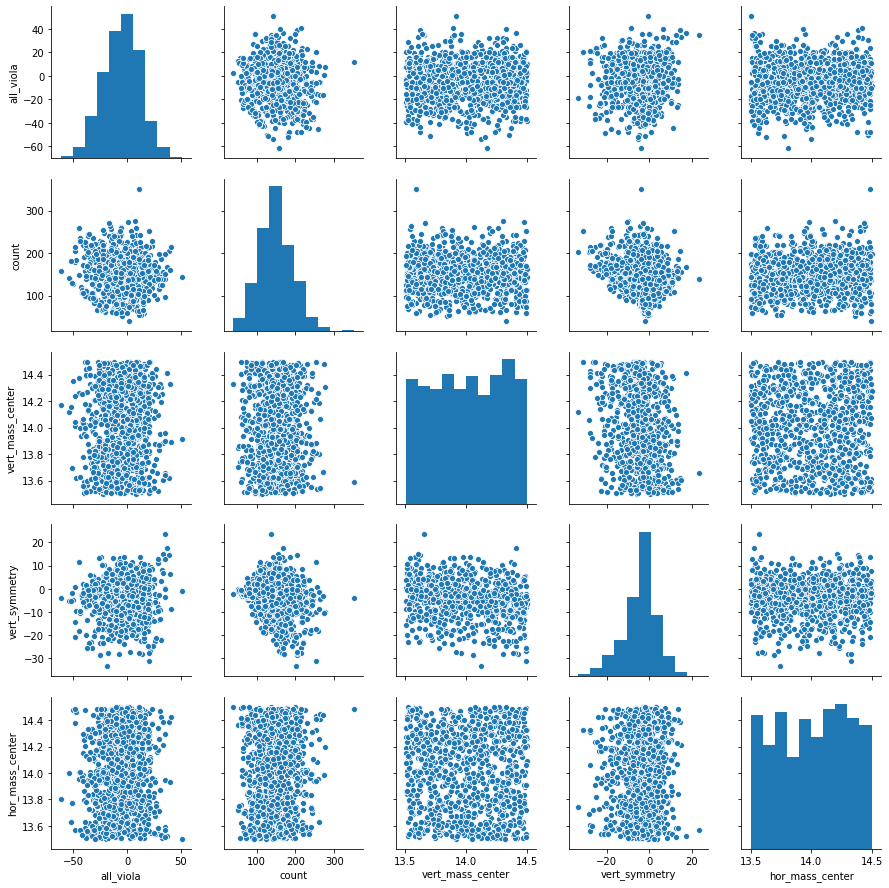

In [6]:
sns.pairplot(train[clustering_features])

Now, after normalizing the data we could fit KMeans and anylize result. We will look at features means and comprare them to the grand mean (the mean of the all dataset):

In [8]:
kmeans_five_criterion, labels_five = fit_kmeans(train_scaled, clustering_features, 5, 10)
kmeans_nine_criterion, labels_nine = fit_kmeans(train_scaled, clustering_features, 9, 10)

data_mean = train[clustering_features + ['label']].mean()
data_mean.name = 'data_mean'

In [9]:
train['clusters_five'] = labels_five
results_five_clusters = train.groupby('clusters_five')[clustering_features + ['label']].mean()
results_five_clusters = results_five_clusters.append(data_mean)
results_five_clusters

,all_viola,count,vert_mass_center,vert_symmetry,hor_mass_center,label
clusters_five,,,,,,
0,-11.112132,235.852941,13.961299,-7.241409,13.997987,3.117647
1,-2.642699,123.061856,13.999458,-2.435567,14.023690,5.350515
2,-3.103468,155.922830,14.028823,-5.370956,13.986778,5.118971
3,-6.526573,82.371212,13.997653,-1.700854,14.008330,2.628788
4,-7.895254,191.262626,14.010742,-5.472068,14.035645,3.939394
data_mean,-4.914597,149.084000,14.007992,-4.179515,14.010802,4.488000


But before looking at the statistics let's look at the difference between intializations:

In [10]:
pd.DataFrame(kmeans_five_criterion, 
             index = ["run #" + str(x) for x in range(1, 11)], 
             columns = ['inertia']
)

,inertia
run #1,145129.696990
run #2,145129.696990
run #3,145129.696990
run #4,143725.213854
run #5,145129.696990
run #6,145129.696990
run #7,143401.114822
run #8,145129.696990
run #9,143669.358087
run #10,142755.246007


In [11]:
pd.DataFrame(kmeans_nine_criterion, 
             index = ["run #" + str(x) for x in range(1, 11)], 
             columns = ['inertia']
)

,inertia
run #1,50166.822931
run #2,51838.225796
run #3,50547.522511
run #4,52146.190736
run #5,50663.232046
run #6,53200.972709
run #7,51369.145662
run #8,52556.691301
run #9,52829.927544
run #10,50239.172400


According to the inertia the best runs are #10 and #3 for five and nine clusters case respectively

In [12]:
rel_difference = 100 * (results_five_clusters.iloc[:-1] - results_five_clusters.loc['data_mean']) \
                / results_five_clusters.loc['data_mean']
rel_difference.columns = [x + '_diff, %' for x in rel_difference.columns]


rel_difference 

,"all_viola_diff, %","count_diff, %","vert_mass_center_diff, %","vert_symmetry_diff, %","hor_mass_center_diff, %","label_diff, %"
clusters_five,,,,,,
0,126.104653,58.201377,-0.333330,73.259542,-0.091471,-30.533711
1,-46.227547,-17.454686,-0.060919,-41.726089,0.091987,19.218259
2,-36.852033,4.587232,0.148707,28.506674,-0.171469,14.059070
3,32.799764,-44.748456,-0.073803,-59.304989,-0.017646,-41.426295
4,60.649055,28.291853,0.019636,30.925890,0.177314,-12.223843


In [13]:
pd.crosstab(train['clusters_five'], train['label'])

label,0,1,2,3,4,5,6,7,8,9
clusters_five,,,,,,,,,,
0,28,0,9,8,0,3,3,0,16,1
1,7,20,23,16,44,37,30,54,16,44
2,22,2,39,29,38,37,38,27,40,39
3,0,88,2,5,3,5,6,20,0,3
4,54,0,26,25,10,11,13,5,41,13


In [14]:
train['clusters_nine'] = labels_nine
results_nine_clusters = train.groupby('clusters_nine')[clustering_features + ['label']].mean()
results_nine_clusters = results_nine_clusters.append(data_mean)
results_nine_clusters

,all_viola,count,vert_mass_center,vert_symmetry,hor_mass_center,label
clusters_nine,,,,,,
0,-4.270217,103.750000,14.000169,-1.324596,14.022913,4.925000
1,-6.352165,173.013889,14.008623,-6.848303,13.996636,4.576389
2,-9.243666,254.344828,13.978287,-7.247889,14.065292,3.137931
3,-1.979398,137.962025,14.011172,-2.807317,13.996167,5.670886
4,-6.924267,195.750000,13.997166,-5.007403,14.029399,3.848214
5,-9.224460,75.068966,14.001101,-1.690916,14.025337,1.827586
6,-10.764338,218.086207,13.993165,-5.953466,14.007416,3.258621
7,-1.324156,122.275862,13.997150,-3.514822,14.020952,5.241379
8,-3.128798,154.875000,14.037175,-5.225591,13.993704,4.909091


In [15]:
abs_difference = results_nine_clusters.iloc[:-1] - results_nine_clusters.loc['data_mean']
abs_difference.columns = [x + '_diff' for x in abs_difference.columns]

abs_difference

,all_viola_diff,count_diff,vert_mass_center_diff,vert_symmetry_diff,hor_mass_center_diff,label_diff
clusters_nine,,,,,,
0,0.644380,-45.334000,-0.007822,2.854919,0.012110,0.437000
1,-1.437568,23.929889,0.000632,-2.668788,-0.014166,0.088389
2,-4.329069,105.260828,-0.029705,-3.068374,0.054490,-1.350069
3,2.935199,-11.121975,0.003180,1.372198,-0.014636,1.182886
4,-2.009670,46.666000,-0.010825,-0.827887,0.018596,-0.639786
5,-4.309864,-74.015034,-0.006891,2.488599,0.014534,-2.660414
6,-5.849742,69.002207,-0.014827,-1.773951,-0.003387,-1.229379
7,3.590441,-26.808138,-0.010842,0.664693,0.010150,0.753379
8,1.785799,5.791000,0.029183,-1.046076,-0.017098,0.421091


In [16]:
rel_difference = 100 * (results_nine_clusters.iloc[:-1] - results_nine_clusters.loc['data_mean']) \
                / results_nine_clusters.loc['data_mean']
rel_difference.columns = [x + '_diff, %' for x in rel_difference.columns]


rel_difference 

,"all_viola_diff, %","count_diff, %","vert_mass_center_diff, %","vert_symmetry_diff, %","hor_mass_center_diff, %","label_diff, %"
clusters_nine,,,,,,
0,-13.111555,-30.408360,-0.055843,-68.307423,0.086434,9.737077
1,29.250982,16.051279,0.004509,63.853996,-0.101109,1.969449
2,88.085952,70.605047,-0.212057,73.414578,0.388914,-30.081751
3,-59.724101,-7.460207,0.022702,-32.831512,-0.104461,26.356642
4,40.891851,31.301816,-0.077279,19.808211,0.132729,-14.255475
5,87.695158,-49.646531,-0.049191,-59.542772,0.103738,-59.278382
6,119.027901,46.284113,-0.105844,42.443930,-0.024172,-27.392587
7,-73.056681,-17.981901,-0.077397,-15.903590,0.072443,16.786527
8,-36.336640,3.884387,0.208332,25.028645,-0.122036,9.382596


In [17]:
pd.crosstab(train['clusters_nine'], train['label'])

label,0,1,2,3,4,5,6,7,8,9
clusters_nine,,,,,,,,,,
0,0,26,4,7,15,12,9,30,1,16
1,18,0,25,14,15,13,15,10,24,10
2,14,0,2,2,0,1,2,0,8,0
3,7,2,13,10,23,19,15,21,18,30
4,35,0,12,15,1,7,9,2,24,7
5,0,73,0,2,0,1,2,9,0,0
6,22,0,8,8,0,3,1,1,14,1
7,1,8,11,5,18,17,17,20,7,12
8,14,1,24,20,23,20,20,13,17,24


Interpretation: 

9 clusters case:

* Cluster five has the biggest difference with grand mean in feature "count". It means that in average case there are more black pixels in cluster five than in the whole sample.

* Cluster zero has a lot of similar statistics compared to the data mean. For example, mean_diff and vert_mass_center_diff are 1.4 and 0.12 percents respectively. It shows us that the distribution of different digits in cluster zero is almost the same as in the whole sample.

* Cluster three has a big difference in all_viola feature because there most popular digit in this clusters are zero and which have one of the biggest viola mean in the whole dataset.

5 clusters case:

This case is more interesting for analysis because we see a big relative difference in almost every claster when comparing to the grand mean of every feature. Let's see:

* Cluster two has the smallest mean of the feature named count. It could be easily explained by analyzing the most popular digit in the cluster. It's a digit 1, which almost doesn't have white pixels. That is why this cluster  has the smallest mean of feature count.

* Like in the 9 clusters case there is a cluster which has some features that does not differ from grand mean. For example, mean and vert_mass_center_diff


Overall, the clusterization is very noisy for both cases. We could see that by looking ath distribution of digits between the clusters. There are always some clusters that contain each type of digits and they also have very small relative difference in their mean. This clusterization technique will be much better if we add raw features from the data or more features created based on raw data.